In [ ]:
pip install nlmpy

In [4]:
import random
import matplotlib.pyplot as plt


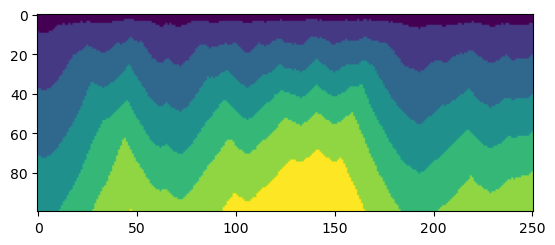

In [5]:
# Import packages
import numpy as np
from skimage import graph
import nlmpy

# Set random seed so results are the same each time script runs
# np.random.seed(1)


# Create a hypothetical cost-surface
# cs = np.random.rand(5000, 100)
def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n


slopes = moving_average(np.random.rand(300), n=50)
cs = np.vstack([slopes**5] * 100)

# Make any values below one equal to no data
# np.place(cs, cs < 1, -9999)
# Specify the size of the cell
cellSize = 10

# From the cost-surface create a 'landscape graph' object which can then be
# analysed using least-cost modelling
lg = graph.MCP_Geometric(cs, sampling=(cellSize, cellSize))

# Set starting points
start_array = np.zeros(cs.shape)
start_array[0, :] = 1
starts = list(zip(*np.nonzero(start_array)))

# Calculate the least-cost distance from the start cell to all other cells
lcd = lg.find_costs(starts=starts)[0]
plt.imshow((lcd > np.quantile(lcd, 0.05)).astype(int) +
           (lcd > np.quantile(lcd, 0.2)).astype(int) +
           (lcd > np.quantile(lcd, 0.4)).astype(int) +
           (lcd > np.quantile(lcd, 0.6)).astype(int) +
           (lcd > np.quantile(lcd, 0.8)).astype(int) +
           (lcd > np.quantile(lcd, 0.95)).astype(int))


In [9]:
cs

array([[0.01637594, 0.01655684, 0.01515336, ..., 0.0277987 , 0.03263238,
        0.03230241],
       [0.01637594, 0.01655684, 0.01515336, ..., 0.0277987 , 0.03263238,
        0.03230241],
       [0.01637594, 0.01655684, 0.01515336, ..., 0.0277987 , 0.03263238,
        0.03230241],
       ...,
       [0.01637594, 0.01655684, 0.01515336, ..., 0.0277987 , 0.03263238,
        0.03230241],
       [0.01637594, 0.01655684, 0.01515336, ..., 0.0277987 , 0.03263238,
        0.03230241],
       [0.01637594, 0.01655684, 0.01515336, ..., 0.0277987 , 0.03263238,
        0.03230241]])

In [ ]:
slopes.repeat(50, axis=0)

In [ ]:
import numpy as np
from skimage import graph
import matplotlib.pyplot as plt
# import nlmpy

# Set random seed so results are the same each time script runs
# np.random.seed(1)

slopes = np.array([0.10, 0.08, 0.05, 0.02, 0.03, 0.04, 0.08, 0.15])
cs = np.vstack([slopes] * 10)

# Make any values below one equal to no data
# np.place(cs, cs < 1, -9999)
# Specify the size of the cell
cellSize = 10

# From the cost-surface create a 'landscape graph' object which can then be
# analysed using least-cost modelling
lg = graph.MCP_Geometric(cs, sampling=(cellSize, cellSize))

# Set starting points
start_array = np.zeros(cs.shape)
start_array[0, :] = 1
starts = list(zip(*np.nonzero(start_array)))

# Calculate the least-cost distance from the start cell to all other cells
lcd, trace = lg.find_costs(starts=starts, 
                           ends=[(-1, 0)], 
                           find_all_ends=False)
lcd[~np.isfinite(lcd)] = np.nan


In [ ]:
plt.imshow(lcd)
plt.colorbar()
print(slopes)
print(' ')
print(lcd.round(2))

In [ ]:
traceback = lg.traceback(np.unravel_index(np.nanargmax(lcd), lcd.shape))
indices = np.array(traceback).T
path = np.zeros_like(lcd)
path[indices[0], indices[1]] = 1
plt.imshow(path)

In [ ]:
trace

In [ ]:
plt.imshow(lcd > 0.9)

## Real world test

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from skimage import graph
import matplotlib.pyplot as plt
from shapely.geometry import Point
from rasterio.features import rasterize

import warnings
import pandas as pd
pd.options.mode.chained_assignment = None
warnings.simplefilter(action='ignore', category=FutureWarning)



def cost_distance(cs, start_array, cellsize=10):

    # From the cost-surface create a 'landscape graph' object which can then be
    # analysed using least-cost modelling
    lg = graph.MCP_Geometric(cs, sampling=(cellsize, cellsize))

    # Set starting points
    starts = list(zip(*np.nonzero(start_array)))

    # Calculate the least-cost distance from the start cell to all other cells
    lcd = lg.find_costs(starts=starts)[0]

    return lcd

def line_mndwi(row):
    x_vals = xr.DataArray(row.geometry.coords.xy[0], dims='z')
    y_vals = xr.DataArray(row.geometry.coords.xy[1], dims='z')   
    return mndwi_i.interp(x=x_vals, y=y_vals).mean().item()



def transect_distances(transects_gdf, lines_gdf):

    def _intersect_dist(transect_gdf, lines_gdf):

        intersect_points = lines_gdf.apply(
            lambda x: x.geometry.intersection(transect_gdf.geometry), axis=1)

        return intersect_points.apply(
            lambda x: x.distance(transect_gdf.start_point))

    # Determine start of transect
    transects_gdf['start_point'] = transects_gdf.apply(
        lambda x: Point(list(x.geometry.coords)[0]), axis=1)

    # Run distance calculation
    distance_df = transects_gdf.apply(lambda x: 
                                      _intersect_dist(x, lines_gdf), axis=1)
    return distance_df.replace(0, np.nan)


def waterbody_masking(input_data, modification_data, da):
    """
    Generates a raster mask for DEACoastlines based on the 
    SurfaceHydrologyPolygonsRegional.gdb dataset, and a vector 
    file containing minor modifications to this dataset (e.g. 
    features to remove or add to the dataset).
    
    The mask returns True for perennial 'Lake' features, any 
    'Aquaculture Area', 'Estuary', 'Watercourse Area', 'Salt 
    Evaporator', and 'Settling Pond' features. Features of 
    type 'add' from the modification data file are added to the
    mask, while features of type 'remove' are removed.
    
    Parameters:
    -----------
    input_data : string
        A string giving the path to the file containing surface water
        polygons (e.g. SurfaceHydrologyPolygonsRegional.gdb)
    modification_data : string
        A string giving the path to a vector file containing 
        modifications to the waterbody file. This vector file should
        contain polygon features with an attribute field 'type'
        indicating whether the function should 'add' or 'remove' the 
        feature from the waterbody mask.
    bbox : geopandas.GeoSeries
        A `geopandas.GeoSeries` giving the spatial extent to load data 
        for. This object should include a CRS.
    da : xr.Dataset or xr.DataArray
        The shape, coordinates, dimensions, and transform of this object 
        are used to build the rasterized shapefile. It effectively 
        provides a template. 
        
    Returns:
    --------
    waterbody_mask : xr.DataArray
        An xr.DataArray containing the rasterised surface water features.
    
    """
    
    # Get bounding box to load data for
    bbox = gpd.GeoSeries(da.geobox.extent.geom, 
                         crs=da.geobox.crs)    

    # Import SurfaceHydrologyPolygonsRegional data
    waterbody_gdf = gpd.read_file(input_data,
                                  bbox=bbox).to_crs(da.geobox.crs)

    # Restrict to coastal features
    lakes_bool = ((waterbody_gdf.FEATURETYPE == 'Lake') &
                  (waterbody_gdf.PERENNIALITY == 'Perennial'))
    other_bool = waterbody_gdf.FEATURETYPE.isin([
        'Aquaculture Area', 'Estuary', 'Watercourse Area', 'Salt Evaporator',
        'Settling Pond'
    ])
    waterbody_gdf = waterbody_gdf[lakes_bool | other_bool]

    # Load in modification dataset and select features to remove/add
    mod_gdf = gpd.read_file(modification_data, bbox=bbox).to_crs(da.crs)
    to_remove = mod_gdf[mod_gdf['type'] == 'remove']
    to_add = mod_gdf[mod_gdf['type'] == 'add']

    # Remove and add features
    if len(to_remove.index) > 0:
        if len(waterbody_gdf.index) > 0:
            waterbody_gdf = gpd.overlay(waterbody_gdf,
                                        to_remove,
                                        how='difference')
    if len(to_add.index) > 0:
        if len(waterbody_gdf.index) > 0:
            waterbody_gdf = gpd.overlay(waterbody_gdf, to_add, how='union')
        else:
            waterbody_gdf = to_add

    # Rasterize waterbody polygons into a numpy mask. The try-except catches
    # cases where no waterbody polygons exist in the study area
    try:
        waterbody_mask = rasterize(shapes=waterbody_gdf['geometry'],
                                   out_shape=da.geobox.shape,
                                   transform=da.geobox.transform,
                                   all_touched=True).astype(bool)
    except:
        waterbody_mask = np.full(da.geobox.shape, False, dtype=bool)

    return xr.DataArray(waterbody_mask, coords=ds.geobox.xr_coords())


def nearest_neighbour(gdf):
    """
    For each point in a geopandas.GeoDataFrame, identify the nearest 
    neighbouring point and distance to that point.
    """
    
    from shapely.ops import nearest_points
       
    def _nearest_neighbour_point(row, gdf):
        point = row.geometry
        multipoint = gdf.drop(row.name, axis=0).geometry.unary_union
        _, nearest_point = nearest_points(point, multipoint)
        return pd.Series({'nearest_point': nearest_point, 
                'nearest_dist': point.distance(nearest_point)})
    
    # Identify distance to nearest neighbour for each point in the dataset
    nearest_neighbours = gdf.apply(
        lambda x: _nearest_neighbour_point(x, gdf), axis=1)
    
    return nearest_neighbours


def tide_mask(distance_da, mndwi_i, tide='low'): 
    """
    Takes array giving least-cost distance from a satellite derived
    shoreline, and generates a mask with True values on the seaward or 
    landward side of the satellite-derived shoreline depending on 
    whether the shoreline was at low or high tide.
    
    Without this mask, tide-corrected shorelines would be mapped on both
    sides of the satellite-derived shoreline as the least-cost distance
    array has no concept of landward or seaward direction. This mask 
    ensures that only one output shoreline is generated by, for example,
    ensuring a low tide shoreline is shifted landward by masking out the 
    seaward portion of the distance array.
    """
    
    from skimage.segmentation import watershed
    from skimage.feature import peak_local_max
    from scipy import ndimage as ndi
    from skimage.measure import regionprops
    
    def _regionprops_nanmean(i):
        return np.nanmean(np.where(i.intensity_image != 0, 
                                   i.intensity_image, 
                                   np.nan))
    
    # Set NAN to zero distance
    valid_data = ~distance_da.isnull().values
    distance = distance_da.where(valid_data, 0).values
    
    # Find local max distance peaks along edges of distance pixels
    coords = peak_local_max(distance, footprint=np.ones((10, 10)))
    
    # Using these peaks, label image using watershed segmentation
    mask = np.zeros(distance.shape, dtype=bool)
    mask[tuple(coords.T)] = True
    markers, _ = ndi.label(mask)
    labels = watershed(-distance, markers, mask=valid_data)
    
    # Reproject MNDWI surface into same resolution as distance array
    mndwi_highres = xr_reproject(mndwi_i,
                                 geobox=distance_da.geobox)
    
    # For each labelled region, calculate MNDWI zonal statistics 
    mndwi_regions = regionprops(label_image=labels,
                                intensity_image=mndwi_highres.values)
    
    # Depending on tide stage, select regions with negative/positive MNDWI
    if tide == 'low':
        labels_subset = [i.label for i in mndwi_regions if
                         _regionprops_nanmean(i) < 0]
    elif tide == 'high':
        labels_subset = [i.label for i in mndwi_regions if
                         _regionprops_nanmean(i) > 0]    
    
    tide_mask = np.isin(labels, labels_subset)

    return xr.DataArray(tide_mask, 
                        coords=distance_da.geobox.xr_coords()).where(valid_data)

In [ ]:
transects_gdf = gpd.read_file('Australia_slopes_by_transect.geojson')
beaches_gdf = gpd.read_file('Australia_slopes_by_beach.geojson')

In [ ]:
name = 'narrabeen'
beach_query = "beach_id == 'aus0206'"

# name = 'stockton'
# beach_query = "beach_id == 'aus0173'"

# name = 'goldcoast'
# beach_query = "beach_id == 'aus0046'"

# name = 'roebuck'
# beach_query = "beach_id == 'aus1731'"

# name = 'byron'
# beach_query = "beach_id == 'aus0055'" 

# name = 'mackay'
# beach_query = "beach_id == 'aus3888'"

# name = 'nt'
# beach_query = "beach_id == 'aus2715'"

# name = 'wamberal'
# beach_query = "beach_id == 'aus0190'"

# name = 'oldbar'
# beach_query = "beach_id == 'aus0149'"

# name = 'test'
# beach_query = "beach_id == 'aus0070'"

In [ ]:
# Load beach and transect data
beach_gdf = beaches_gdf.query(beach_query).copy()
beach_transects_gdf = transects_gdf.query(beach_query).copy()  #.iloc[10:65]

# Expand transects to avoid shorelines being clipped at low and high tide
beach_transects_gdf['geometry'] = beach_transects_gdf.scale(xfact=2, yfact=2)

# Buffer each transect point to provide a study area
buffer_gdf = gpd.GeoDataFrame(geometry=beach_gdf.buffer(350, cap_style=2))
buffer_gdf.plot(alpha=0.3)
beach_gdf.plot(ax=plt.gca(), color='black')
beach_transects_gdf.plot(ax=plt.gca(), column='Beach-face Slope', cmap='viridis')

In [ ]:
from datacube.utils import geometry
from datacube.utils.geometry import GeoBox, assign_crs
import xarray as xr
from dea_tools.spatial import interpolate_2d
from dea_tools.spatial import xr_rasterize

cell_size = 2

# Create a geopolygon based on buffered study area dimensions
geopoly = geometry.Geometry(geom=buffer_gdf.geometry.iloc[0],
                            crs=beach_transects_gdf.crs)
geobox = GeoBox.from_geopolygon(geopoly, resolution=(-cell_size, cell_size))

# Use this to create an empty xr.DataArray
da = xr.DataArray(coords=geobox.xr_coords(with_crs=True), dims=['y', 'x'])

# Extract points from transects
points = gpd.GeoSeries([beach_transects_gdf.unary_union.interpolate(i) for 
                        i in range(0, int(beach_transects_gdf.length.sum()), 50)])
points_gdf = gpd.GeoDataFrame(geometry=points, crs=beach_transects_gdf.crs)
points_gdf = points_gdf.sjoin_nearest(beach_transects_gdf)

# Remove overlapping points
points_gdf = points_gdf.loc[nearest_neighbour(points_gdf).nearest_dist > 20]

# Interpolate points into array dimensions
slope_da = interpolate_2d(ds=da,
                          x_coords=points_gdf.geometry.x,
                          y_coords=points_gdf.geometry.y,
#                           z_coords=points_gdf['Beach-face Slope'],
                          z_coords=points_gdf['Lower Confidence Bound'],
                          method='linear')
slope_da = assign_crs(slope_da, crs=beach_gdf.crs)

# Plot
buffer_slope_da = xr_rasterize(gdf=buffer_gdf, da=slope_da)
slope_da = slope_da.where(buffer_slope_da)
slope_da.plot.imshow(size=10, robust=True)
points_gdf.plot(ax=plt.gca(), column='Beach-face Slope', markersize=20, edgecolor='black', linewidth=0.5)
beach_gdf.plot(ax=plt.gca(), color='black')

### Run cost analysis

In [ ]:
import datacube
from datacube.utils.masking import mask_invalid_data
from dea_tools.spatial import subpixel_contours
from dea_tools.coastal import tidal_tag
from dea_tools.datahandling import load_ard
dc = datacube.Datacube()

In [ ]:
ds = dc.load(product=['s2a_ard_granule', 's2b_ard_granule'],
        measurements=['nbart_green', 'nbart_swir_2', 'fmask'],
        geopolygon=geopoly,
        output_crs=geopoly.crs,
        resolution=(-10, 10),
        resampling={'*': 'cubic', 'fmask': 'nearest'},
#         dask_chunks={},
        group_by='solar_day',
        time='2020')

# ds = load_ard(dc=dc,
#               products=['s2a_ard_granule', 's2b_ard_granule'],
#               measurements=['nbart_green', 'nbart_swir_2'],
#               fmask_categories=['valid', 'snow', 'water'],
#               mask_pixel_quality=False,
#               geopolygon=geopoly,
#               output_crs=geopoly.crs,
#               resolution=(-10, 10),
#               resampling={'*': 'cubic', 'fmask': 'nearest'},
#               dask_chunks={},
#               time='2020',
#               group_by='solar_day',
#               min_gooddata=0.3)

# Remove NAs
ds = mask_invalid_data(ds)

In [ ]:
from datacube.utils.masking import make_mask

ds.fmask.flags_definition

In [ ]:
import odc.algo

# Extract boolean mask
mask = odc.algo.enum_to_bool(
    ds.fmask, categories=['nodata', 'cloud', 'shadow'])

# Close mask to remove small holes in cloud, open mask to
# remove narrow false positive cloud, then dilate
mask_cleaned = odc.algo.mask_cleanup(mask=mask,
                                     mask_filters=[('erosion', 5)])




# .mean(dim='time')

In [ ]:
test_mask = (mask_cleaned.mean(dim='time') > 0.75)   #.plot()

In [ ]:
good_times = mask_cleaned.where(~test_mask).mean(dim=['x','y']) < 0.3

In [ ]:
ds = ds.sel(time=good_times)  #.plot(col='time', col_wrap=5)

In [ ]:
# ds.nbart_green.isel(time=3).plot()

In [ ]:
# ds.fmask.isel(time=3).plot()

In [ ]:
# mask.isel(time=3).plot()

In [ ]:
# mask_cleaned.isel(time=3).plot()

In [ ]:
# !pip install git+https://github.com/GeoscienceAustralia/dea-coastlines.git

In [ ]:
# from dea_coastlines.vector import waterbody_masking
from odc.algo import xr_reproject

# Create waterbody mask to remove inland waterbodies and estuaries
waterbody_mask = ~waterbody_masking(
    input_data='../../dea-coastlines/data/raw/SurfaceHydrologyPolygonsRegional.gdb',
    modification_data='../../dea-coastlines/data/raw/estuary_mask_modifications.geojson',
    da=ds)

# Reproject a copy of this array this into the higher slope array resolution
waterbody_mask_slope = xr_reproject(waterbody_mask.astype(np.int16),
                                    geobox=slope_da.geobox)

In [ ]:
# Clip to buffer
buffer_da = xr_rasterize(gdf=buffer_gdf, da=ds)
# ds_masked = ds
ds_masked = ds.where(waterbody_mask).where(buffer_da)

In [ ]:
# Coarse cloud filter
green_mean = ds_masked.nbart_green.mean(dim=['x', 'y'])  
good_times = green_mean < 2000
ds_masked = ds_masked.sel(time=good_times)

# Convert to MNDWI
mndwi = ((ds_masked.nbart_green - ds_masked.nbart_swir_2) / (ds_masked.nbart_green + ds_masked.nbart_swir_2))

# Tidal tag
mndwi = tidal_tag(mndwi)

In [ ]:
ds_masked.nbart_green.mean(dim=['x', 'y']).plot()

In [ ]:
mndwi.plot(col='time', col_wrap=5)

In [ ]:
satellite_list = []
corrected_list = []

for (date, mndwi_i) in mndwi.groupby('time'):  # .isel(time=slice(5, 10))
# for (date, mndwi_i) in mndwi.isel(time=slice(7, 8)).groupby('time'):  # 

    
    try:
    
        # Load data, obtain tide height
#         mndwi_i = mndwi_i.compute()    
        tide_height = mndwi_i.tide_height.item()
        print(tide_height)

        # Extract satellite-derived shoreline
        out = subpixel_contours(da=mndwi_i, 
                                z_values=0, 
                                crs=beach_transects_gdf.crs, 
                                affine=mndwi_i.geobox.affine,
                                attribute_df=pd.DataFrame({'tide_m': [tide_height]}),
                                min_vertices=50,
                               ).drop('z_value', axis=1)
        out['date'] = str(mndwi_i.time.values)[0:10]
        
        # Set NaN based on valid buffer area
        slope_da = slope_da.where(waterbody_mask_slope)

        # Convert to raster giving locations to model distances from
        start_array = xr_rasterize(gdf=out, da=slope_da)    
        start_array = start_array.where(~slope_da.isnull(), 0)

        # Calculate accumulated cost distance array
        lcd_da = xr.apply_ufunc(cost_distance, slope_da.where(~slope_da.isnull(), -1),
                                start_array, cell_size)
        lcd_da = lcd_da.where(np.isfinite(lcd_da))
        lcd_da = assign_crs(lcd_da, slope_da.geobox.crs)
        
        # Apply tide mask
        if tide_height <= 0:
            tide_mask_da = tide_mask(lcd_da, mndwi_i, tide='low')
        else:
            tide_mask_da = tide_mask(lcd_da, mndwi_i, tide='high')       
        lcd_da_masked = lcd_da * tide_mask_da

        # Extract tide datum shoreline from cost distance array
        tide_lines = subpixel_contours(da=lcd_da_masked, 
                                       z_values=abs(tide_height),
                                       min_vertices=50,
                                       crs=beach_transects_gdf.crs,
                                       affine=slope_da.geobox.affine)
        tide_lines['tide_m'] = tide_height

        # Simplify to remove artefacts for near-zero observations
        tide_lines['geometry'] = tide_lines.simplify(2)
        tide_lines['date'] = str(mndwi_i.time.values)[0:10]
        
        satellite_list.append(out.clip(buffer_gdf))
        corrected_list.append(tide_lines)
    except:
        print('Failed')

In [ ]:
# Combine and export
satellite_gdf = pd.concat(satellite_list, ignore_index=True).sort_values('date')
satellite_gdf['length'] = satellite_gdf.geometry.length
satellite_gdf.to_file(filename=f'instantaneous_{name}_satellite.geojson') 
corrected_gdf = pd.concat(corrected_list, ignore_index=True).sort_values('date')
corrected_gdf['length'] = corrected_gdf.geometry.length
corrected_gdf.to_file(filename=f'instantaneous_{name}_corrected_lower.geojson') 

# Filter to shared subset
shared_dates = corrected_dist.columns.intersection(satellite_dist.columns)[5:]
corrected_dist = corrected_dist.loc[:,shared_dates]
satellite_dist = satellite_dist.loc[:,shared_dates]
nodata = np.logical_or(corrected_dist.isnull(), satellite_dist.isnull())
corrected_dist = corrected_dist.where(~nodata)
satellite_dist = satellite_dist.where(~nodata)

In [ ]:
corrected_dist = transect_distances(transects_gdf=beach_transects_gdf.set_index('transect_id'), 
                   lines_gdf=corrected_gdf.dissolve('date'))

In [ ]:
satellite_dist = transect_distances(transects_gdf=beach_transects_gdf.set_index('transect_id'), 
                   lines_gdf=satellite_gdf.dissolve('date'))

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 10))
transect_id = corrected_dist.index[7]
# transect_id = 'aus0190-009'
corrected_dist.loc[transect_id].rename('Tide corrected').plot(ax=axes[0])
satellite_dist.loc[transect_id].rename('Uncorrected').plot(ax=axes[0])
axes[0].legend()

# Buffer each transect point to provide a study area
# buffer_gdf.plot(ax=axes[1], alpha=0.3)
beach_gdf.plot(ax=axes[1], color='black')
beach_transects_gdf.plot(ax=axes[1], column='Beach-face Slope', cmap='viridis')
beach_transects_gdf.set_index('transect_id').loc[[transect_id]].plot(ax=axes[1], 
                                                                     color='red', 
                                                                     linewidth=5)
fig.suptitle(transect_id);

In [ ]:
corrected_dist.std(axis=1).loc[transect_id]

In [ ]:
satellite_dist.std(axis=1).loc[transect_id]

In [ ]:
corrected_dist.std(axis=1).median()

In [ ]:
satellite_dist.std(axis=1).median()

In [ ]:

from datacube.utils.cog import write_cog
write_cog(start_array, 'start_array.tif', overwrite=True )

In [ ]:
from datacube.utils.cog import write_cog
write_cog(slope_da, 'slope_da.tif', overwrite=True )

In [ ]:
from datacube.utils.cog import write_cog
from datacube.utils.geometry import assign_crs
write_cog(lcd_da, 'lcd_da.tif', overwrite=True )

In [ ]:
satellite_dist.std(axis=1)

## Animation

In [ ]:
import contextily as ctx
fig, axes = plt.subplots(1, 2, figsize=(15, 8))
fig.tight_layout(pad=0)

# Set extent
# minx, miny, maxx, maxy = corrected_gdf.buffer(200).total_bounds
x, y = -1247800, -2125100
buffer = 1000
minx, miny, maxx, maxy = x - buffer, y - buffer, x + buffer, y + buffer

for i in range(1, len(satellite_gdf.index)+1):
    # i = 5

    satellite_gdf.head(i).plot(ax=axes[0], 
                               column='tide_m', 
                               cmap='RdYlBu', 
                               linewidth=3, 
                               vmin=-3, vmax=3)
    corrected_gdf.head(i).plot(ax=axes[1], 
                               column='tide_m', 
                               cmap='RdYlBu', 
                               linewidth=3, 
                               vmin=-3, vmax=3)

    date_str = satellite_gdf.head(i).date.iloc[-1]
    tide_str = satellite_gdf.head(i).tide_m.iloc[-1]

    axes[0].annotate(text=f'{date_str}\n'
                          f'Tide height: {tide_str:.2f} m', 
                     fontsize=14,
                     weight='bold',
                     color='black',
                     xy=(0.03, 0.93), 
                     xycoords='axes fraction')

    axes[1].annotate(text=f'{date_str}\n'
                          f'Tide height: 0.00 m', 
                     fontsize=14,
                     weight='bold',
                     color='black',
                     xy=(0.03, 0.93), 
                     xycoords='axes fraction')

    # set bounds
    for ax in axes:
        ax.set_ylim(miny, maxy)
        ax.set_xlim(minx, maxx)
        ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)

        # Add basemap
        ctx.add_basemap(ax, 
                        source='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}', 
                        crs=corrected_gdf.crs,
                        alpha=0.9)

    fig.savefig(f'test_{i}.jpg', bbox_inches='tight')
    axes[0].cla()  
    axes[1].cla()



In [ ]:
!ffmpeg -y -r 3 -start_number 1 -i test_%d.jpg -vf "format=yuv420p,pad=ceil(iw/2)*2:ceil(ih/2)*2" temp.mp4